In [180]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
import matplotlib.pyplot as plt

In [181]:
def gauss2Drot(n, m, s, theta):
    
    x, y = np.meshgrid(range(n[0]), range(n[1]))

    x = x - x.mean()
    y = y - y.mean()

    coords = np.vstack((
        x.flatten(),
        y.flatten(),
        np.zeros(n[0] * n[1])
    ))

    t = np.radians(theta)
    rotz = np.array([
        [np.cos(t), -np.sin(t), 0],
        [np.sin(t), np.cos(t), 0],
        [0, 0, 1],
    ])

    coords = np.matmul(rotz, coords)
    x = np.reshape(coords[0], [n[1],n[0]])
    y = np.reshape(coords[1], [n[1],n[0]])

    sx, sy = s
    mx, my = m

    ex = (x - mx)/sx
    ey = (y - my)/sy

    e = ex*ex + ey*ey
    return np.exp(-e)

def fftconv(x, y):
    a = fft2(x)
    b = fft2(y)
    
    return np.real(ifftshift(ifft2(a * b)))

def pwr(x):
    p = np.abs(x)
    p = np.log10(p + 1e-20)
    return fftshift(p)

def circ(im, r=10, t=2):
    
    x, y = np.meshgrid(range(im.shape[1]), range(im.shape[0]))
    x = x - x.mean()
    y = y - y.mean()

    c = (x**2 + y**2 < (r+t)**2).astype(int)
    c -= (x**2 + y**2 < r**2).astype(int)   

    return c 

def wiener_filt(x, alpha=0.005):
    X = fft2(x)
    X = X / (X**2 + alpha)
    return X

def rms(a : np.ndarray, b : np.ndarray):
    a = a / a.sum()
    b = b / b.sum()
    
    err = a - b
    err = err**2

    return np.sqrt(err.mean())

def ctrcrop(x, w=48, h=48):
    cy, cx = x.shape
    cx = int(cx/2)
    cy = int(cy/2)

    return x[(cy-h):(cy+h), (cx-w):(cx+w)]

def norm(x):
    x -= x.min()
    return x / x.max()

from matplotlib.axes import Axes
def ksp_ticks(ax : Axes ):    
    xt = ax.get_xticks()
    yt = ax.get_yticks()

    nx = len(xt)
    ny = len(yt)
    
    dx = xt[1] - xt[0]
    dy = yt[1] - yt[0]

    ax.set_xticklabels([f"{x:.4f}" for x in fftshift(fftfreq(nx, d=dx))])
    ax.set_yticklabels([f"{y:.3f}" for y in fftshift(fftfreq(ny, d=dy))])

In [182]:
# ---- Parameters ----

# image dimensions
m = 800
n = 512

# psf
pSize = [20,4]
tiltAngle = 50

# downsampling
dsFactor = 4

In [183]:
# ---- Toy Image ----

qn = int(n/4)
qm = int(m/4)
h = 25

# toy image
raw = np.zeros((n,m))
raw[qn:qn+h,      qm:qm+h] = 1
raw[qn:qn+h,  3*qm-h:3*qm] = 1
raw[3*qn-h:3*qn,  qm:qm+h] = 1

raw += circ(raw, r=40)
raw += circ(raw, r=75, t=5)

raw[2*qn, 2*qm] = 10

raw = raw / raw.sum()

C:\Users\conor\AppData\Local\Temp\ipykernel_7700\1812372752.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.4f}" for x in fftshift(fftfreq(nx, d=dx))])
C:\Users\conor\AppData\Local\Temp\ipykernel_7700\1812372752.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y:.3f}" for y in fftshift(fftfreq(ny, d=dy))])
C:\Users\conor\AppData\Local\Temp\ipykernel_7700\1812372752.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.4f}" for x in fftshift(fftfreq(nx, d=dx))])
C:\Users\conor\AppData\Local\Temp\ipykernel_7700\1812372752.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

Text(0.5, 0.0, '|im - g_recon|')

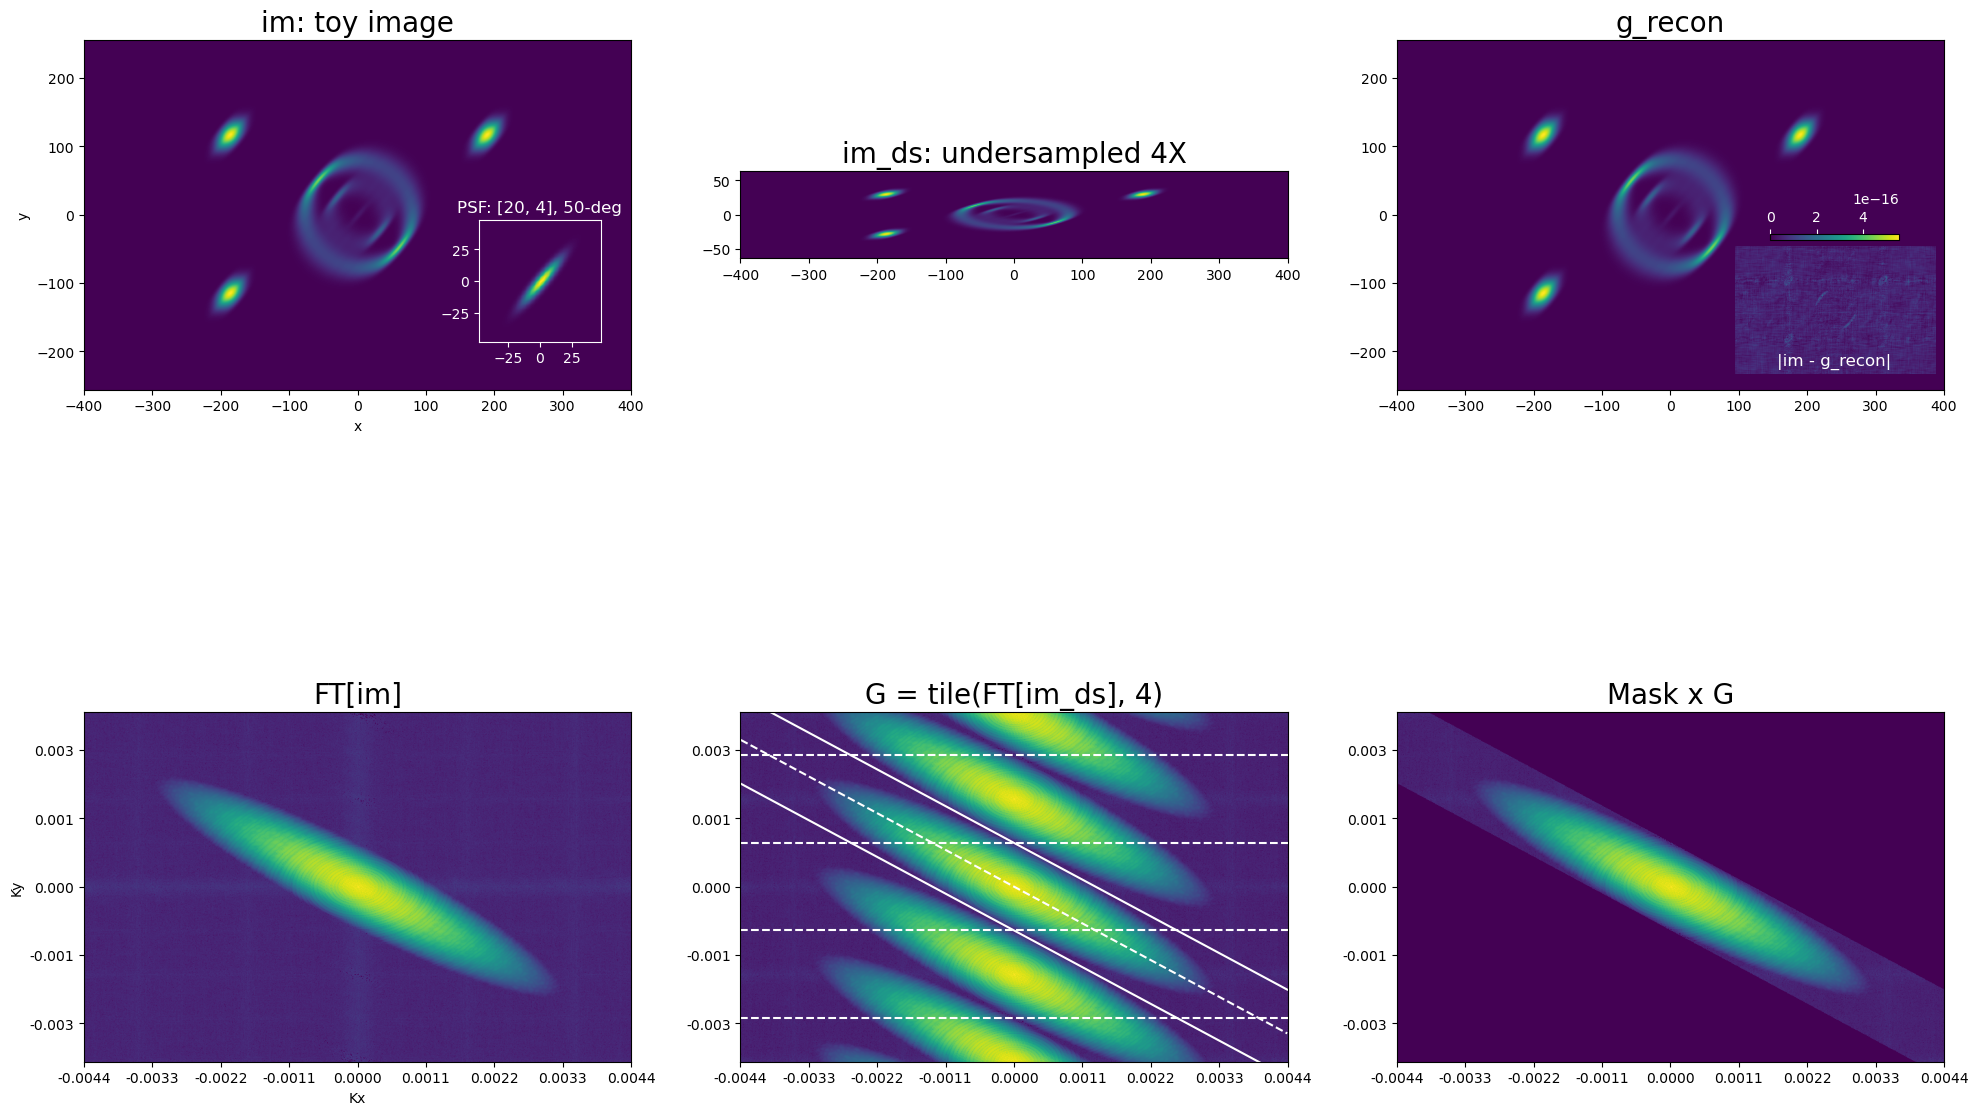

In [184]:
# ---- SIMULATION ----

psf = gauss2Drot([m,n], [1,1], pSize, tiltAngle)
psf = psf / psf.sum()

# blur
im = fftconv(raw, psf)

# domains:
ext = [-m/2, m/2, -n/2, n/2]

fig, ax = plt.subplots(2,3, figsize=(24,16))

ax[0][0].imshow(im, extent=ext)
ax[0][0].set_title("im: toy image", fontsize=20)
ax[0][0].set_xlabel("x")
ax[0][0].set_ylabel("y")

p = ax[0][0].get_position().bounds
ax_inlay = fig.add_axes([p[0] + p[2]*2/3, p[1] + 0.03, p[2]/3, p[2]/3])

pw = 48
ax_inlay.imshow(ctrcrop(psf, w=pw, h=pw), extent=[-pw, pw, -pw, pw])
ax_inlay.set_title(f"PSF: {pSize}, {tiltAngle}-deg", color='w')
ax_inlay.tick_params(axis='x', colors='w')
ax_inlay.tick_params(axis='y', colors='w')
_ = [s.set_color('w') for s in ax_inlay.spines.values()]

comb = np.zeros_like(im)
comb[::dsFactor, :] = 1
im_ds = im * comb

ax[0][1].imshow(im_ds[im_ds.any(1) > 0], extent=[-m/2, m/2, -n/dsFactor/2, n/dsFactor/2])
ax[0][1].set_title(f"im_ds: undersampled {dsFactor}X", fontsize=20)

# G
G = fft2(im_ds)

sy, sx = G.shape
alpha = np.radians(90-tiltAngle)

x, y = np.meshgrid(np.arange(sx), np.arange(sy))
x_mid = x.mean()
y_mid = y.mean()
x = x.astype(float) - x_mid
y = y.astype(float) - y_mid

# shift for even dsFactor case
y_mid -= float(not np.mod(dsFactor, 2)) * sy/dsFactor/2

xyAspect = sx/sy

ax[1][0].imshow(pwr(fft2(im)), extent=ext)
ax[1][0].set_title("FT[im]", fontsize=20)
ax[1][0].set_xlabel("Kx")
ax[1][0].set_ylabel("Ky")

ksp_ticks(ax[1][0])

ax[1][1].imshow(pwr(G), extent=ext)
y_i = np.arange(G.shape[0])
l_y = y_i[np.mod(y_i, int(sy/dsFactor)) == 0]
ax[1][1].hlines(l_y - y_mid, ext[0], ext[1], linestyles='--', color='w')

ax[1][1].plot(x[0], np.tan(alpha) * x[0][::-1]/xyAspect + sy/dsFactor/2, color='w')
ax[1][1].plot(x[0], np.tan(alpha) * x[0][::-1]/xyAspect - sy/dsFactor/2, color='w')
ax[1][1].plot(x[0], np.tan(alpha) * x[0][::-1]/xyAspect, '--', color='w')

ax[1][1].set_xlim((ext[0], ext[1]))
ax[1][1].set_ylim((ext[2], ext[3]))
ax[1][1].set_title(f"G = tile(FT[im_ds], {dsFactor})", fontsize=20)

ksp_ticks(ax[1][1])

# pick out central lobe:
mask = y > np.tan(alpha) * x/xyAspect + sy/dsFactor/2
mask += y < np.tan(alpha) * x/xyAspect - sy/dsFactor/2
mask = np.logical_not(mask)

G_mask = ifftshift(mask * fftshift(G))
ax[1][2].imshow(pwr(G_mask), extent=ext)
ax[1][2].set_title("Mask x G", fontsize=20)

ksp_ticks(ax[1][2])

# IFT
g_recon = np.real(ifft2(G_mask))
ax[0][2].imshow(g_recon, extent=ext)
ax[0][2].set_title("g_recon", fontsize=20)

p = ax[0][2].get_position().bounds

ax_error = fig.add_axes([p[0] + 0.6*p[2], p[1] + 0.01, 0.4*p[2], 0.4*p[3]])
abs_err = np.abs(norm(im) - norm(g_recon))
err_im = ax_error.imshow(abs_err)
ax_error.set_axis_off()
cbar = plt.colorbar(err_im, location='top', fraction=0.046, pad=0.04)
cbar.ax.tick_params(colors='w')
plt.title("|im - g_recon|", color='w', x=0.5, y=0.0)